# Analyse Water Deficit from ISIMIP2b
Main script to analyse the processed water scarcity from ISIMIP2b


In [1]:
# import modules
import os
import xarray as xr
import matplotlib.pyplot as plt
from init import *
from functions import *
import pandas as pd
import cartopy.crs as ccrs
import pickle as pk

# to show plots in the notebook
%matplotlib inline 
set_plot_param()


map_proj = ccrs.Robinson(central_longitude=0, globe=None)


/apps/brussel/RL8/broadwell/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# define ISIMIP models, forcings and variables
models    =  ['H08', 'WaterGAP2-2e', 'CWatM'] #,'H08'] #, 'WaterGAP2-2e' 
forcings  = ['gfdl-esm4', 'ipsl-cm6a-lr','mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll'] # 


# special cases, the settings are included in init
if phase == '2b':
    models    =  [ 'LPJmL','CWatM','MATSIRO', 'H08']
    forcings  = ['gfdl-esm2m', 'ipsl-cm5a-lr', 'hadgem2-es', 'miroc5']

if histsoc_scenario == '2015soc':
    # only waterGAP: CWatM has no historical - 2015soc simulations, 
    # H08 has unrealistic water withdrawals (previous issue, no updates provided by Naota)
    models    =  ['WaterGAP2-2e']
    

In [3]:
# Load routing data

# da_flowdir = xr.open_dataarray(routingdir +'ddm30_flowdir_cru_neva.nc')
da_basins  = xr.open_dataarray(routingdir +'ddm30_basins_cru_neva.nc')
# da_slopes  = xr.open_dataarray(routingdir +'ddm30_slopes_cru_neva.nc')

# load cell area
da_cellarea = xr.open_dataarray(outdir +'upstream_calc/cellarea.nc')

# load land mask
landmask = da_basins>0
landmask['names'] = 'Global' # assing name, for plotting purpose

# preprocess basins
save_basinfile()

# get countries
d_countries = pk.load(open(lifetimerootdir+'/data/pickles/country_info.pkl', 'rb'))
countries_regions, countries_mask = d_countries['mask']
df_countries = d_countries['info_pop']


# create mask for medditerean 
regions_mask = create_regionsmask(landmask)
med_mask = regions_mask.sel(region=19)

# Load population
fn_pop = 'corrected_with_regionmask_population_histsoc_rcp26soc_0p5deg_annual_1861-2100.nc4'
pop = load_pop(fn_pop)


# Diagnostics

## per country

In [4]:
# load intermediate variable per forcing, scenario and model -- including lat and lon
def load_intermediate_variable_ds_country(variable, mask,  models, scenarios, forcings, weights):
   
    if phase == '3b': 
        decode_times = True 
    else: 
        decode_times = False
        
        
    # loop over models
    model_list = []
    for model in models:
        print('Loading model '+model)
        scenario_list = []
        for scenario in scenarios:
            ds_forcings = xr.Dataset()
            # loop over GCM forcings

            area_exposed_list = []
            for forcing in forcings: 

                # define filename and output directory of model

                filedir, filename = get_simulation_name_dir(variable, outdir+'intermediate/', model, forcing, scenario, 'monthly')
                if filename!='false': 
                    # save to output location
                    ds = xr.open_dataset(filedir+filename, engine='netcdf4', decode_times=decode_times)[variable]
                    
                    # for isimip 2b, manually assign time periods, as these can not be read in 
                    if phase=='2b': 
                        ds['time'] = d_time_ncfile[scenario]
                                            
                    ds_var = ds.where(mask, drop=True)
                    
                    # weight based on population
                    da_weighted_fldsum = ds_var.weighted(weights).mean(dim=("lat", "lon"))

                    #select one grid cell 
                    #    ds_var_tosave = ds_var.sel({'lat':mode[0], 'lon':mode[1]})
                    del ds_var
                else: 
                    if scenario == 'historical': 
                        empty_array = np.empty_like(area_exposed_list[0].values)

                    else: 
                        empty_array = np.empty_like(area_exposed_list[1].values)
                    
                    empty_array[:] = np.nan    
                    da_weighted_fldsum = xr.DataArray(empty_array, dims=('time'))
                
                area_exposed_list.append(da_weighted_fldsum)


            ds_scenario = xr.concat(area_exposed_list, dim='forcing').assign_coords({'forcing':forcings})
            scenario_list.append(ds_scenario)                                         
        ds_model = xr.concat(scenario_list, dim='scenario').assign_coords({'scenario':scenarios})
        model_list.append(ds_model)

    ds_var_full = xr.concat(model_list,dim='model').assign_coords({'model':models})
    return ds_var_full


def load_deficit_country(country, models, scenarios, forcings, pop, countries_mask, countries_regions, process_simulations=False):
    
    country_mask = countries_mask == countries_regions.map_keys(country)
    
    # load raw data, cut out grid cell and save as pickle
    if process_simulations: 
        # load raw data, cut out grid cell and save as pickle
        print('Load and process all simulations')

        q_avail = load_intermediate_variable_ds_country('q_avail', country_mask,  models, scenarios, forcings, pop).squeeze()
        ptotww = load_intermediate_variable_ds_country('ptotww', country_mask,  models, scenarios, forcings, pop).squeeze()


        # do processing of q avail and withdrawal
        days_in_month = []
        for q_avail_month in ptotww.time.values:
            days_in_month.append(pd.to_datetime(q_avail_month).days_in_month)

        secs_in_month = np.expand_dims(np.array(days_in_month) * 24*60*60, axis=(0))

        pop_cell = pop.where(country_mask).mean().values
        cellarea = da_cellarea.where(country_mask).mean().values

        # calculate water deficit
        water_deficit = ((ptotww - q_avail) * cellarea/1000  * secs_in_month.squeeze())  #m³


        wa = (q_avail*cellarea/1000 * secs_in_month.squeeze())
        withdrawal = (ptotww*cellarea/1000 * secs_in_month.squeeze())
        
        

        water_deficit_annual = water_deficit.where(water_deficit>0).groupby('time.year').sum().rename({'year':'time'})


        # save grid cell wa and availability as a pickle
        d_gridcell_deficit = {'wa': wa , 'withdrawal': withdrawal, 'water_deficit':water_deficit_annual}


        with open('./data/intermediate/d_deficit_'+country+'.pkl', 'wb') as f:
            pk.dump(d_gridcell_deficit,f)
    
    
    # load the preprocessed pickle (saves a lot of time)
    else: 
        print('Load saved pickles')
        with open('./data/intermediate/d_deficit_'+country+'.pkl', 'rb') as f:
            d_gridcell_deficit = pk.load(f)
        wa = d_gridcell_deficit['wa']
        withdrawal = d_gridcell_deficit['withdrawal']
        water_deficit_annual = d_gridcell_deficit['water_deficit']

    return wa, withdrawal, water_deficit_annual

## Per gridcell

In [5]:
# load intermediate variable per forcing, scenario and model -- including lat and lon
def load_intermediate_variable_ds_gridcell(variable, mask,  models, scenarios, forcings, mode):
   

    if phase == '3b': 
        decode_times = True 
    else: 
        decode_times = False
        
        
    # loop over models
    model_list = []
    for model in models:
        print('Loading model '+model)
        scenario_list = []
        for scenario in scenarios:
            ds_forcings = xr.Dataset()
            # loop over GCM forcings

            area_exposed_list = []
            for forcing in forcings: 

                # define filename and output directory of model

                filedir, filename = get_simulation_name_dir(variable, outdir+'intermediate/', model, forcing, scenario, 'monthly')
                if filename!='false': 
                    # save to output location
                    ds = xr.open_dataset(filedir+filename, engine='netcdf4', decode_times=decode_times)[variable]
                    
                    # for isimip 2b, manually assign time periods, as these can not be read in 
                    if phase=='2b': 
                        ds['time'] = d_time_ncfile[scenario]
                        
                    ds_var = ds#.groupby('time.year').mean()
                    
                    ds_var_tosave = ds_var.where(mask)
                    
                    #select one grid cell 
                    ds_var_tosave = ds_var.sel({'lat':mode[0], 'lon':mode[1]})
                    del ds_var
                else: 
                    if scenario == 'historical': 
                        empty_array = np.empty_like(area_exposed_list[0].values)

                    else: 
                        empty_array = np.empty_like(area_exposed_list[1].values)
                    
                    empty_array[:] = np.nan    
                    ds_var_tosave = xr.DataArray(empty_array, dims=('time'))
                
                area_exposed_list.append(ds_var_tosave)


            ds_scenario = xr.concat(area_exposed_list, dim='forcing').assign_coords({'forcing':forcings}).mean('forcing')
            scenario_list.append(ds_scenario)                                         
        ds_model = xr.concat(scenario_list, dim='scenario').assign_coords({'scenario':scenarios})
        model_list.append(ds_model)

    ds_var_full = xr.concat(model_list,dim='model').assign_coords({'model':models})
    return ds_var_full



def load_deficit_gridcell(gridcell, models, scenarios, forcings, process_simulations=False):
    
    coordinate = str(gridcell[0])+'_ '+str(gridcell[1])
    
    # load raw data, cut out grid cell and save as pickle
    if process_simulations: 
        print('Load and process all simulations')

        q_avail = load_intermediate_variable_ds_gridcell('q_avail', landmask,  models, scenarios, forcings, gridcell).squeeze()
        ptotww = load_intermediate_variable_ds_gridcell('ptotww', landmask,  models, scenarios, forcings, gridcell).squeeze()


        # do processing of q avail and withdrawal
        days_in_month = []
        for q_avail_month in ptotww.time.values:
            days_in_month.append(pd.to_datetime(q_avail_month).days_in_month)

        secs_in_month = np.expand_dims(np.array(days_in_month) * 24*60*60, axis=(0))

        pop_cell = pop.sel({'lat':gridcell[0], 'lon':gridcell[1]})
        cellarea_cell = da_cellarea.sel({'lat':gridcell[0], 'lon':gridcell[1]}).squeeze()

        # calculate water deficit
        water_deficit = ((ptotww - q_avail) * cellarea_cell/1000  * secs_in_month)  #m³


        wa = (q_avail*cellarea_cell/1000 * secs_in_month)#.groupby('time.year').sum().rename({'year':'time'})
        withdrawal = (ptotww*cellarea_cell/1000 * secs_in_month)#.groupby('time.year').sum().rename({'year':'time'})

        water_deficit_annual = water_deficit.where(water_deficit>0).groupby('time.year').sum().rename({'year':'time'})


        # save grid cell wa and availability as a pickle
        d_gridcell_deficit = {'wa': wa , 'withdrawal': withdrawal, 'water_deficit':water_deficit_annual}

       

        with open('./data/intermediate/d_gridcell_deficit_'+coordinate+'.pkl', 'wb') as f:
            pk.dump(d_gridcell_deficit,f)

    
    
    # load the preprocessed pickle (saves a lot of time)
    else: 
        print('Load saved pickles')
        with open('./data/intermediate/d_gridcell_deficit_'+coordinate+'.pkl', 'rb') as f:
            d_gridcell_deficit = pk.load(f)
        wa = d_gridcell_deficit['wa']
        withdrawal = d_gridcell_deficit['withdrawal']
        water_deficit_annual = d_gridcell_deficit['water_deficit']

    return wa, withdrawal, water_deficit_annual

In [6]:
gridcell = [30.25,-8.75] # Morroco
wa, withdrawal, water_deficit_annual = load_deficit_gridcell(gridcell, models, scenarios, forcings, process_simulations=False)

Load saved pickles


Load saved pickles


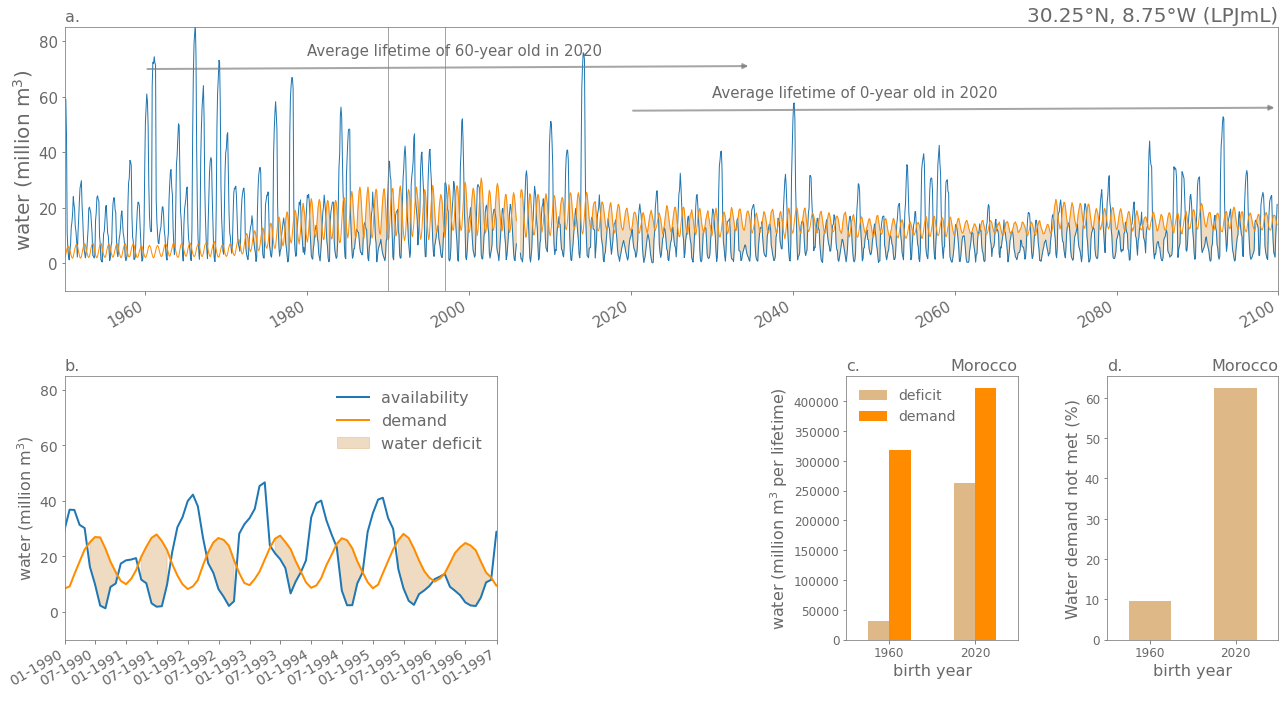

In [7]:
# zoomed figure

model = 'LPJmL'
ylims = [-10,85]
offset=0

deficit_color = 'burlywood'
demand_color = 'darkorange'
import matplotlib.dates as mdates

ncols = 10
fig = plt.figure(figsize=(18,10))
ax1 = plt.subplot2grid(shape=(2,ncols), loc=(1,0), colspan=4)


minzoom= '1990'
maxzoom = '1997'
coordinate = str(wa.lat.values)+'°N, '+str(abs(wa.lon.values))+'°W'

scenario='historical'
wa_toplot = (wa.sel(model=model).sel({'scenario':scenario}).rolling(time=6, center=True).mean()*10**-6)
withdrawal_toplot = (withdrawal.sel(model=model).sel({'scenario':scenario}).rolling(time=6, center=True).mean()*10**-6)

#fig, ax = plt.subplots(figsize=(10,5))

wa_toplot.plot(ax=ax1, label='availability', linewidth=2);
withdrawal_toplot.plot(ax=ax1, label='demand', color=demand_color, linewidth=2);

ax1.fill_between(wa_toplot.time, wa_toplot , withdrawal_toplot, where =  (wa_toplot-offset) <= (withdrawal_toplot), color=deficit_color , alpha=0.5, label='water deficit')

ax1.legend(frameon=False, fontsize=16);
ax1.set_ylabel('water (million m$^3$)', fontsize=16); 
ax1.set_ylim(ylims);
ax1.set_xlim(pd.to_datetime(minzoom+'-01-01'),pd.to_datetime(maxzoom+'-01-01'));
ax1.tick_params(labelsize=14)
# Make ticks on occurrences of each month:

ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
# Get only the month to show in the x-axis:
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax1.set_xlabel(' ')

ax1.set_title('b.', loc='left', fontsize=16);
ax1.set_title(' ', loc='center');
ax.set_title(coordinate+' ('+model+')', loc='right', fontsize=20);

# ------------------------------------------------------------------------------------------------------------------------------------------------
ax = plt.subplot2grid((2,ncols), (0,0), colspan=ncols)

# larger figure

wa_series_toplot = xr.concat([wa.sel({'scenario':'historical'}),wa.sel({'scenario':'rcp26'})], dim='time').sel(model=model).rolling(time=6, center=True).mean()*10**-6
withdrawal_series_toplot = xr.concat([withdrawal.sel({'scenario':'historical'}),withdrawal.sel({'scenario':'rcp26'})], dim='time').sel(model=model).rolling(time=6, center=True).mean()*10**-6


#fig, ax = plt.subplots(figsize=(20,5))

wa_series_toplot.plot(ax=ax, label='availability', linewidth=1);
withdrawal_series_toplot.plot(ax=ax, label='demand', color=demand_color, linewidth=1);

ax.fill_between(wa_series_toplot.time, wa_series_toplot, withdrawal_series_toplot, where =  (wa_series_toplot-offset) <= (withdrawal_series_toplot), color=deficit_color , alpha=0.5, label='water deficit')

#ax.legend(frameon=False, fontsize=20);
ax.set_ylabel('water (million m$^3$)', fontsize=20); 
ax.set_ylim(ylims);
ax.set_xlabel(' ')
ax.set_xlim(pd.to_datetime('1950-01-01'),pd.to_datetime('2100-01-01'));
ax.tick_params(labelsize=15)

# Make ticks on occurrences of each month:
#ax.xaxis.set_major_locator(mdates.MonthLocator())

# Get only the month to show in the x-axis:
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.set_title(coordinate+' ('+model+')', loc='right', fontsize=20);
ax.set_title(' ', loc='center');
ax.set_title('a.', loc='left', fontsize=16);

xmin = np.where(wa_series_toplot.time.values ==(pd.to_datetime('1960-01-31')))[0][0]
xmax = np.where(wa_series_toplot.time.values ==(pd.to_datetime('2035-01-31')))[0][0]

#ax.hlines(y=600, xmin=pd.to_datetime('1960-01-01'), xmax=pd.to_datetime('2035-01-01'), color='grey', linewidth=2)
yloc = 70
yearmin= '1960'
yearmax = '2035'
yeartext = '1980'
ax.annotate(" ", xy=(pd.to_datetime(yearmin+'-01-01'), yloc), xytext=(pd.to_datetime(yearmax+'-01-01'), yloc),
            arrowprops=dict( arrowstyle='<|-', color='gray', linewidth=2, alpha=0.7))
ax.text( pd.to_datetime(yeartext+'-01-01'), yloc+5, "Average lifetime of 60-year old in 2020", fontsize=15)

#ax.axvline(x = pd.to_datetime(yearmin+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)

# 2020
yloc = 55
yearmin= '2020'
yearmax = '2100'
yeartext = '2030'
ax.annotate(" ", xy=(pd.to_datetime(yearmin+'-01-01'), yloc), xytext=(pd.to_datetime(yearmax+'-01-01'), yloc),
            arrowprops=dict( arrowstyle='<|-', color='gray', linewidth=2, alpha=0.7))
ax.text( pd.to_datetime(yeartext+'-01-01'), yloc+5, "Average lifetime of 0-year old in 2020", fontsize=15)

ax.axvline(x = pd.to_datetime(minzoom+'-01-01'), ymin=0, ymax= 1, color='grey', alpha=0.7, linewidth=1)
ax.axvline(x = pd.to_datetime(maxzoom+'-01-01'), ymin=0, ymax= 1, color='grey', alpha=0.7, linewidth=1)



# ------------------------------------------------------------------------------------------------------------------------------------------------
# BARPLOT

colors = [deficit_color, demand_color]

# calculate mean per country weighted by population
country = 'Morocco'
wa_country, withdrawal_country, water_deficit_annual_country = load_deficit_country(country, models, scenarios, forcings, pop, countries_mask, countries_regions, process_simulations=False)

ax = plt.subplot2grid((2,ncols), (1,6), colspan=2)


waterdeficit = xr.concat([water_deficit_annual_country.sel({'scenario':'historical'}).where(water_deficit_annual_country.time<2006),water_deficit_annual_country.sel({'scenario':'rcp26'}).where(water_deficit_annual_country.time>2005)], dim='time').sel(model=model)*10**-6

waterdemand = xr.concat([withdrawal_country.sel({'scenario':'historical'}).where(withdrawal_country.time<pd.to_datetime('2006-01-31')),withdrawal_country.sel({'scenario':'rcp26'}).where(withdrawal_country.time>pd.to_datetime('2005-01-31'))], dim='time').sel(model=model)*10**-6

df_life_expectancy_5 = d_countries['life_expectancy_5']
life_expectancy_60yr = int(np.round(df_life_expectancy_5['Morocco'].loc[1960]))
life_expectancy_0yr = int(np.round(df_life_expectancy_5['Morocco'].loc[2020]))

lifetime_waterdeficit_60yr = float(waterdeficit.where(waterdeficit.time.isin(np.arange(1960, 1960+life_expectancy_60yr+1))).sum().values) *1e-6
lifetime_waterdeficit_0yr = float(waterdeficit.where(waterdeficit.time.isin(np.arange(2020, 2020+life_expectancy_0yr+1))).sum().values) *1e-6

lifetime_waterdemand_60yr = float(withdrawal.sel(time=slice('1960-01-31', str(1960+life_expectancy_60yr)+'-01-31')).sum().values) *1e-6
lifetime_waterdemand_0yr = float(withdrawal.sel(time=slice('2020-01-31', str(2020+life_expectancy_0yr)+'-01-31')).sum().values) *1e-6


df = pd.DataFrame([[lifetime_waterdeficit_60yr,lifetime_waterdemand_60yr],[lifetime_waterdeficit_0yr,lifetime_waterdemand_0yr]], index=['1960', '2020'], columns=['deficit', 'demand'])
df.plot.bar(ax=ax, rot=0, legend=True, color=colors)

ax.legend(frameon=False, fontsize=14);
ax.set_ylabel('water (million m$^3$ per lifetime)', fontsize=16); 
ax.set_xlabel('birth year', fontsize=16)
ax.set_title('c.', loc='left', fontsize=16);
ax.set_title(country, loc='right', fontsize=16);




# ------------------------------------------------------------------------------------------------------------------------------------------------
ax = plt.subplot2grid((2,ncols), (1,8), colspan=2)


waterdeficit = xr.concat([water_deficit_annual.sel({'scenario':'historical'}).where(water_deficit_annual.time<2006),water_deficit_annual.sel({'scenario':'rcp26'}).where(water_deficit_annual.time>2005)], dim='time').sel(model=model)*10**-6

waterdemand = xr.concat([withdrawal.sel({'scenario':'historical'}).where(withdrawal.time<pd.to_datetime('2006-01-31')),withdrawal.sel({'scenario':'rcp26'}).where(withdrawal.time>pd.to_datetime('2005-01-31'))], dim='time').sel(model=model)*10**-6

df_life_expectancy_5 = d_countries['life_expectancy_5']
life_expectancy_60yr = int(np.round(df_life_expectancy_5['Morocco'].loc[1960]))
life_expectancy_0yr = int(np.round(df_life_expectancy_5['Morocco'].loc[2020]))

lifetime_pct_waterdeficit_60yr = (lifetime_waterdeficit_60yr /lifetime_waterdemand_60yr)*100
lifetime_pct_waterdeficit_0yr = (lifetime_waterdeficit_0yr / lifetime_waterdemand_0yr)*100

df = pd.DataFrame([lifetime_pct_waterdeficit_60yr,lifetime_pct_waterdeficit_0yr], index=['1960', '2020'], columns=['deficit'])
df.plot.bar(ax=ax, rot=0, legend=False, color=deficit_color)

#ax.legend(frameon=False, fontsize=16);
ax.set_ylabel('Water demand not met (%)', fontsize=16); 
ax.set_title('d.', loc='left', fontsize=16);
ax.set_title(country, loc='right', fontsize=16);
ax.set_xlabel('birth year', fontsize=16)


fig.tight_layout()
plt.savefig('/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/lifetime_exposure_isimip/figures/conceptual.png', bbox_inches='tight',dpi=100)


In [8]:
gridcell = [30.25,-9.25] # Morroco
wa, withdrawal, water_deficit_annual = load_deficit_gridcell(gridcell, models, scenarios, forcings, process_simulations=False)

Load saved pickles


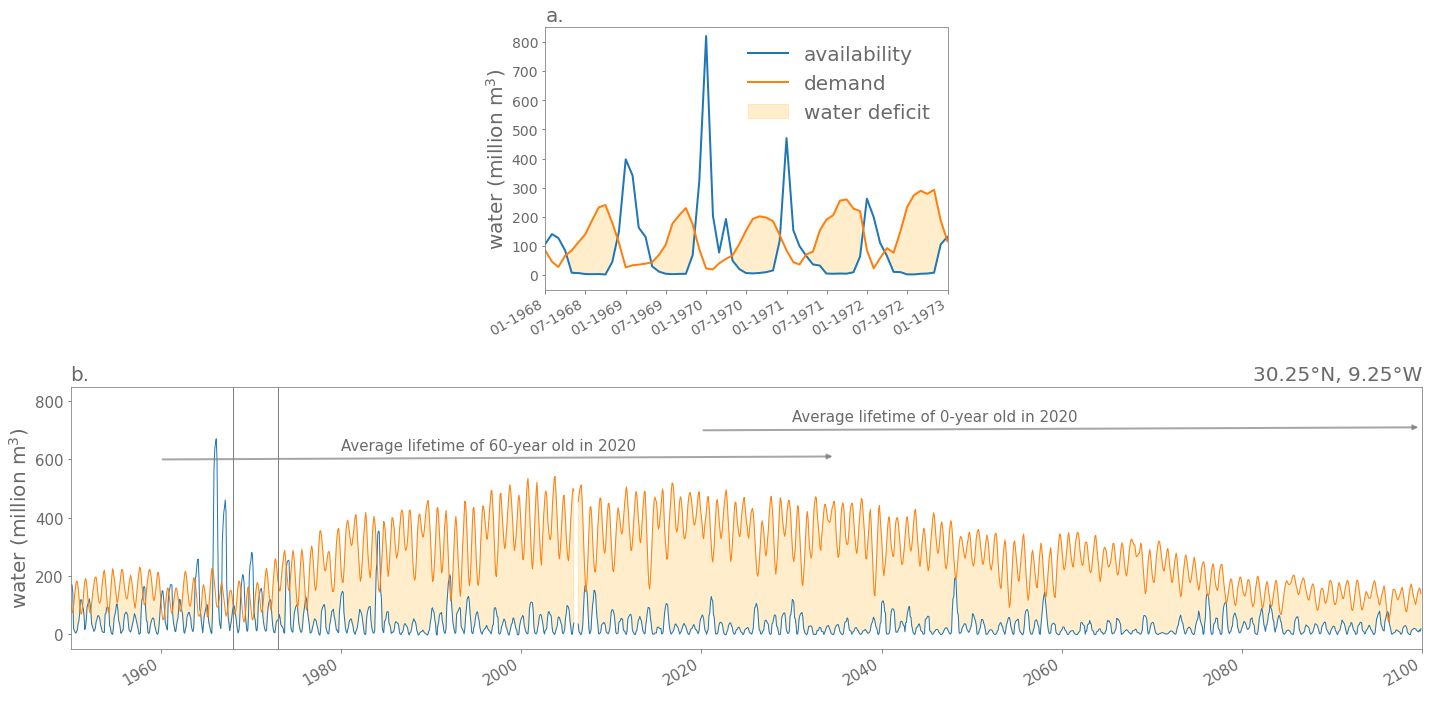

In [9]:
# zoomed figure

import matplotlib.dates as mdates


fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid(shape=(2,3), loc=(0,1), colspan=1)


minzoom= '1968'
maxzoom = '1973'
coordinate = str(wa.lat.values)+'°N, '+str(abs(wa.lon.values))+'°W'

scenario='historical'
wa_toplot = (wa.mean('model').sel({'scenario':scenario})*10**-6)
withdrawal_toplot = (withdrawal.mean('model').sel({'scenario':scenario})*10**-6)

#fig, ax = plt.subplots(figsize=(10,5))

wa_toplot.plot(ax=ax1, label='availability', linewidth=2);
withdrawal_toplot.plot(ax=ax1, label='demand', linewidth=2);

ax1.fill_between(wa_toplot.time, wa_toplot , withdrawal_toplot, where =  (wa_toplot-50) <= (withdrawal_toplot), color='orange' , alpha=0.2, label='water deficit')

ax1.legend(frameon=False, fontsize=20);
ax1.set_ylabel('water (million m$^3$)', fontsize=20); 
ax1.set_ylim(-50,850);
ax1.set_xlim(pd.to_datetime(minzoom+'-01-01'),pd.to_datetime(maxzoom+'-01-01'));
ax1.tick_params(labelsize=14)
# Make ticks on occurrences of each month:

ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
# Get only the month to show in the x-axis:
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax1.set_xlabel(' ')

ax1.set_title('a.', loc='left', fontsize=20);
ax1.set_title(' ', loc='center');

# ------------------------------------------------------------------------------------------------------------------------------------------------
ax = plt.subplot2grid((2,3), (1,0), colspan=3)

# larger figure

wa_series_toplot = xr.concat([wa.sel({'scenario':'historical'}),wa.sel({'scenario':'rcp26'})], dim='time').mean('model').rolling(time=6, center=True).mean()*10**-6
withdrawal_series_toplot = xr.concat([withdrawal.sel({'scenario':'historical'}),withdrawal.sel({'scenario':'rcp26'})], dim='time').mean('model').rolling(time=6, center=True).mean()*10**-6

waterdeficit_series_toplot = xr.concat([water_deficit_annual.sel({'scenario':'historical'}).where(water_deficit_annual.time<2006),water_deficit_annual.sel({'scenario':'rcp26'}).where(water_deficit_annual.time>2005)], dim='time').mean('model')*10**-6/12
waterdeficit_series_toplot['time'] = pd.to_datetime(waterdeficit_series_toplot.time, format='%Y')

#fig, ax = plt.subplots(figsize=(20,5))

wa_series_toplot.plot(ax=ax, label='availability', linewidth=1);
withdrawal_series_toplot.plot(ax=ax, label='demand', linewidth=1);
#waterdeficit_series_toplot.plot(ax=ax, label='deficit', linewidth=1);

ax.fill_between(wa_series_toplot.time, wa_series_toplot, withdrawal_series_toplot, where =  (wa_series_toplot-50) <= (withdrawal_series_toplot), color='orange' , alpha=0.2, label='water deficit')

#ax.legend(frameon=False, fontsize=20);
ax.set_ylabel('water (million m$^3$)', fontsize=20); 
ax.set_ylim(-50,850);
ax.set_xlabel(' ')
ax.set_xlim(pd.to_datetime('1950-01-01'),pd.to_datetime('2100-01-01'));
ax.tick_params(labelsize=15)

# Make ticks on occurrences of each month:
#ax.xaxis.set_major_locator(mdates.MonthLocator())

# Get only the month to show in the x-axis:
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.set_title(coordinate, loc='right', fontsize=20);
ax.set_title(' ', loc='center');
ax.set_title('b.', loc='left', fontsize=20);

xmin = np.where(waterdeficit_series_toplot.time.values ==(pd.to_datetime('1960-01-01')))[0][0]
xmax = np.where(waterdeficit_series_toplot.time.values ==(pd.to_datetime('2035-01-01')))[0][0]

#ax.hlines(y=600, xmin=pd.to_datetime('1960-01-01'), xmax=pd.to_datetime('2035-01-01'), color='grey', linewidth=2)
yloc = 600
yearmin= '1960'
yearmax = '2035'
yeartext = '1980'
ax.annotate(" ", xy=(pd.to_datetime(yearmin+'-01-01'), yloc), xytext=(pd.to_datetime(yearmax+'-01-01'), yloc),
            arrowprops=dict( arrowstyle='<|-', color='gray', linewidth=2, alpha=0.7))
ax.text( pd.to_datetime(yeartext+'-01-01'), yloc+30, "Average lifetime of 60-year old in 2020", fontsize=15)

#ax.axvline(x = pd.to_datetime(yearmin+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)

# 2020
yloc = 700
yearmin= '2020'
yearmax = '2100'
yeartext = '2030'
ax.annotate(" ", xy=(pd.to_datetime(yearmin+'-01-01'), yloc), xytext=(pd.to_datetime(yearmax+'-01-01'), yloc),
            arrowprops=dict( arrowstyle='<|-', color='gray', linewidth=2, alpha=0.7))
ax.text( pd.to_datetime(yeartext+'-01-01'), yloc+30, "Average lifetime of 0-year old in 2020", fontsize=15)

ax.axvline(x = pd.to_datetime(minzoom+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)
ax.axvline(x = pd.to_datetime(maxzoom+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)

fig.tight_layout()

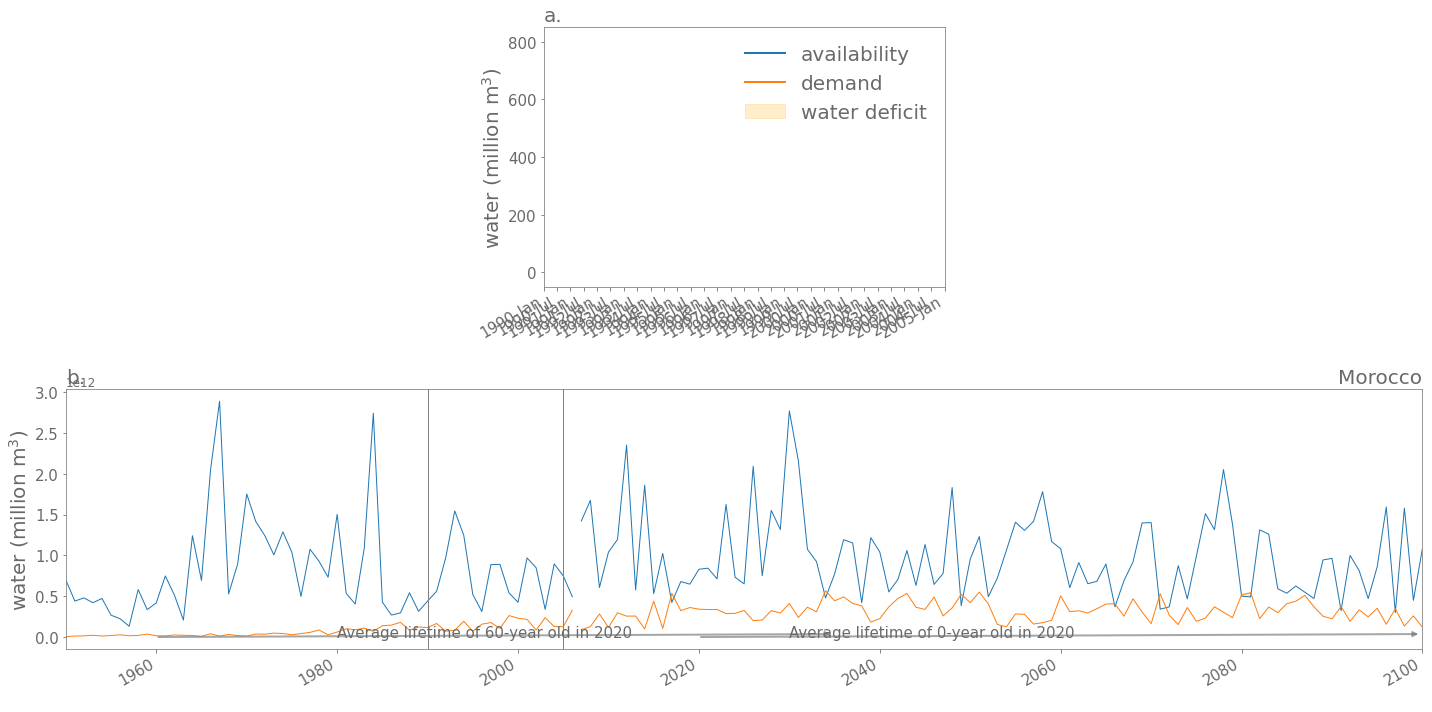

In [11]:
# zoomed figure

rolling_time = 1

import matplotlib.dates as mdates


fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid(shape=(2,3), loc=(0,1), colspan=1)


minzoom= '1990'
maxzoom = '2005'


scenario='historical'
wa_toplot = (wa.mean(dim=('model','forcing')).sel({'scenario':scenario})*10**-6)
withdrawal_toplot = (withdrawal.mean(dim=('model','forcing')).sel({'scenario':scenario})*10**-6)

#fig, ax = plt.subplots(figsize=(10,5))

wa_toplot.plot(ax=ax1, label='availability', linewidth=2);
withdrawal_toplot.plot(ax=ax1, label='demand', linewidth=2);

ax1.fill_between(wa_toplot.time, wa_toplot , withdrawal_toplot, where =  (wa_toplot-50) <= (withdrawal_toplot), color='orange' , alpha=0.2, label='water deficit')

ax1.legend(frameon=False, fontsize=20);
ax1.set_ylabel('water (million m$^3$)', fontsize=20); 
ax1.set_ylim(-50,850);
ax1.set_xlim(pd.to_datetime(minzoom+'-01-01'),pd.to_datetime(maxzoom+'-01-01'));
ax1.tick_params(labelsize=15)
# Make ticks on occurrences of each month:

ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
# Get only the month to show in the x-axis:
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_xlabel(' ')

ax1.set_title('a.', loc='left', fontsize=20);
ax1.set_title(' ', loc='center');

# ------------------------------------------------------------------------------------------------------------------------------------------------
ax = plt.subplot2grid((2,3), (1,0), colspan=3)

# larger figure

wa_series_toplot = xr.concat([wa.sel({'scenario':'historical'}),wa.sel({'scenario':'rcp26'})], dim='time').mean(dim=('model','forcing')).rolling(time=rolling_time, center=True).mean()*10**-6
withdrawal_series_toplot = xr.concat([withdrawal.sel({'scenario':'historical'}),withdrawal.sel({'scenario':'rcp26'})], dim='time').mean(dim=('model','forcing')).rolling(time=rolling_time, center=True).mean()*10**-6

waterdeficit_series_toplot = xr.concat([water_deficit_annual.sel({'scenario':'historical'}).where(water_deficit_annual.time<2006),water_deficit_annual.sel({'scenario':'rcp26'}).where(water_deficit_annual.time>2005)], dim='time').mean(dim=('model','forcing'))*10**-6/12
waterdeficit_series_toplot['time'] = pd.to_datetime(waterdeficit_series_toplot.time, format='%Y')

#fig, ax = plt.subplots(figsize=(20,5))

wa_series_toplot.plot(ax=ax, label='availability', linewidth=1);
withdrawal_series_toplot.plot(ax=ax, label='demand', linewidth=1);
#waterdeficit_series_toplot.plot(ax=ax, label='deficit', linewidth=1);

ax.fill_between(wa_series_toplot.time, wa_series_toplot, withdrawal_series_toplot, where =  (wa_series_toplot-50) <= (withdrawal_series_toplot), color='orange' , alpha=0.2, label='water deficit')

#ax.legend(frameon=False, fontsize=20);
ax.set_ylabel('water (million m$^3$)', fontsize=20); 
#ax.set_ylim(-50,850);
ax.set_xlabel(' ')
ax.set_xlim(pd.to_datetime('1950-01-01'),pd.to_datetime('2100-01-01'));
ax.tick_params(labelsize=15)

# Make ticks on occurrences of each month:
#ax.xaxis.set_major_locator(mdates.MonthLocator())

# Get only the month to show in the x-axis:
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.set_title(country, loc='right', fontsize=20);
ax.set_title(' ', loc='center');
ax.set_title('b.', loc='left', fontsize=20);

xmin = np.where(waterdeficit_series_toplot.time.values ==(pd.to_datetime('1960-01-01')))[0][0]
xmax = np.where(waterdeficit_series_toplot.time.values ==(pd.to_datetime('2035-01-01')))[0][0]

#ax.hlines(y=600, xmin=pd.to_datetime('1960-01-01'), xmax=pd.to_datetime('2035-01-01'), color='grey', linewidth=2)
yloc = 600
yearmin= '1960'
yearmax = '2035'
yeartext = '1980'
ax.annotate(" ", xy=(pd.to_datetime(yearmin+'-01-01'), yloc), xytext=(pd.to_datetime(yearmax+'-01-01'), yloc),
            arrowprops=dict( arrowstyle='<|-', color='gray', linewidth=2, alpha=0.7))
ax.text( pd.to_datetime(yeartext+'-01-01'), yloc+30, "Average lifetime of 60-year old in 2020", fontsize=15)

#ax.axvline(x = pd.to_datetime(yearmin+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)

# 2020
yloc = 700
yearmin= '2020'
yearmax = '2100'
yeartext = '2030'
ax.annotate(" ", xy=(pd.to_datetime(yearmin+'-01-01'), yloc), xytext=(pd.to_datetime(yearmax+'-01-01'), yloc),
            arrowprops=dict( arrowstyle='<|-', color='gray', linewidth=2, alpha=0.7))
ax.text( pd.to_datetime(yeartext+'-01-01'), yloc+30, "Average lifetime of 0-year old in 2020", fontsize=15)

ax.axvline(x = pd.to_datetime(minzoom+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)
ax.axvline(x = pd.to_datetime(maxzoom+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)

fig.tight_layout()

In [9]:
# calculate mean per country weighted by population
country = 'Tanzania'
wa, withdrawal, water_deficit_annual = load_deficit_country(country, models, scenarios, forcings, pop, countries_mask, countries_regions, process_simulations=True)

Load and process all simulations
Loading model LPJmL
Loading model CWatM
Loading model MATSIRO
Loading model H08
Loading model LPJmL
Loading model CWatM
Loading model MATSIRO
Loading model H08


In [ ]:
# calculate mean per country weighted by population
country = 'Madagascar'
wa, withdrawal, water_deficit_annual = load_deficit_country(country, models, scenarios, forcings, pop, countries_mask, countries_regions, process_simulations=True)

In [ ]:
# calculate mean per country weighted by population
country = 'Mauritania'
wa, withdrawal, water_deficit_annual = load_deficit_country(country, models, scenarios, forcings, pop, countries_mask, countries_regions, process_simulations=True)

In [132]:

# ------------------------------------------------------------------------------------------------------------------------------------------------
ax = plt.subplot2grid((2,2), (1,2), colspan=1)


waterdeficit = xr.concat([water_deficit_annual.sel({'scenario':'historical'}).where(water_deficit_annual.time<2006),water_deficit_annual.sel({'scenario':'rcp26'}).where(water_deficit_annual.time>2005)], dim='time').sel(model=model)*10**-6

waterdemand = xr.concat([withdrawal.sel({'scenario':'historical'}).where(withdrawal.time<pd.to_datetime('2006-01-31')),withdrawal.sel({'scenario':'rcp26'}).where(withdrawal.time>pd.to_datetime('2005-01-31'))], dim='time').sel(model=model)*10**-6

df_life_expectancy_5 = d_countries['life_expectancy_5']
life_expectancy_60yr = int(np.round(df_life_expectancy_5['Morocco'].loc[1960]))
life_expectancy_0yr = int(np.round(df_life_expectancy_5['Morocco'].loc[2020]))

lifetime_waterdeficit_60yr = float(water_deficit.where(water_deficit.time.isin(np.arange(1960, 1960+life_expectancy_60yr+1))).sum().values)
lifetime_waterdeficit_0yr = float(water_deficit.where(water_deficit.time.isin(np.arange(2020, 2020+life_expectancy_0yr+1))).sum().values)

lifetime_waterdemand_60yr = float(withdrawal.sel(time=slice('1960-01-31', str(1960+life_expectancy_60yr)+'-01-31')).sum().values)
lifetime_waterdemand_0yr = float(withdrawal.sel(time=slice('2020-01-31', str(2020+life_expectancy_0yr)+'-01-31')).sum().values)


df = pd.DataFrame([[lifetime_waterdeficit_60yr,lifetime_waterdemand_60yr],[lifetime_waterdeficit_0yr,lifetime_waterdemand_0yr]], index=['60 year old in 2020', '0 year old in 2020'], columns=['deficit', 'demand'])
df.plot.bar(ax=ax, rot=0, legend=True)



<AxesSubplot:title={'left':'b.','center':' ','right':'30.25°N, 8.75°W'}, xlabel=' ', ylabel='water (million m$^3$)'>

In [22]:
gridcell = [30.25,28.25] # Cairo
wa, withdrawal, water_deficit_annual = load_deficit_gridcell(gridcell, models, scenarios, forcings, process_simulations=False)

Load saved pickles


In [44]:
gridcell = [23.75,34.75] # East of Lake Nasser
wa, withdrawal, water_deficit_annual = load_deficit_gridcell(gridcell, models, scenarios, forcings, process_simulations=False)

Load saved pickles


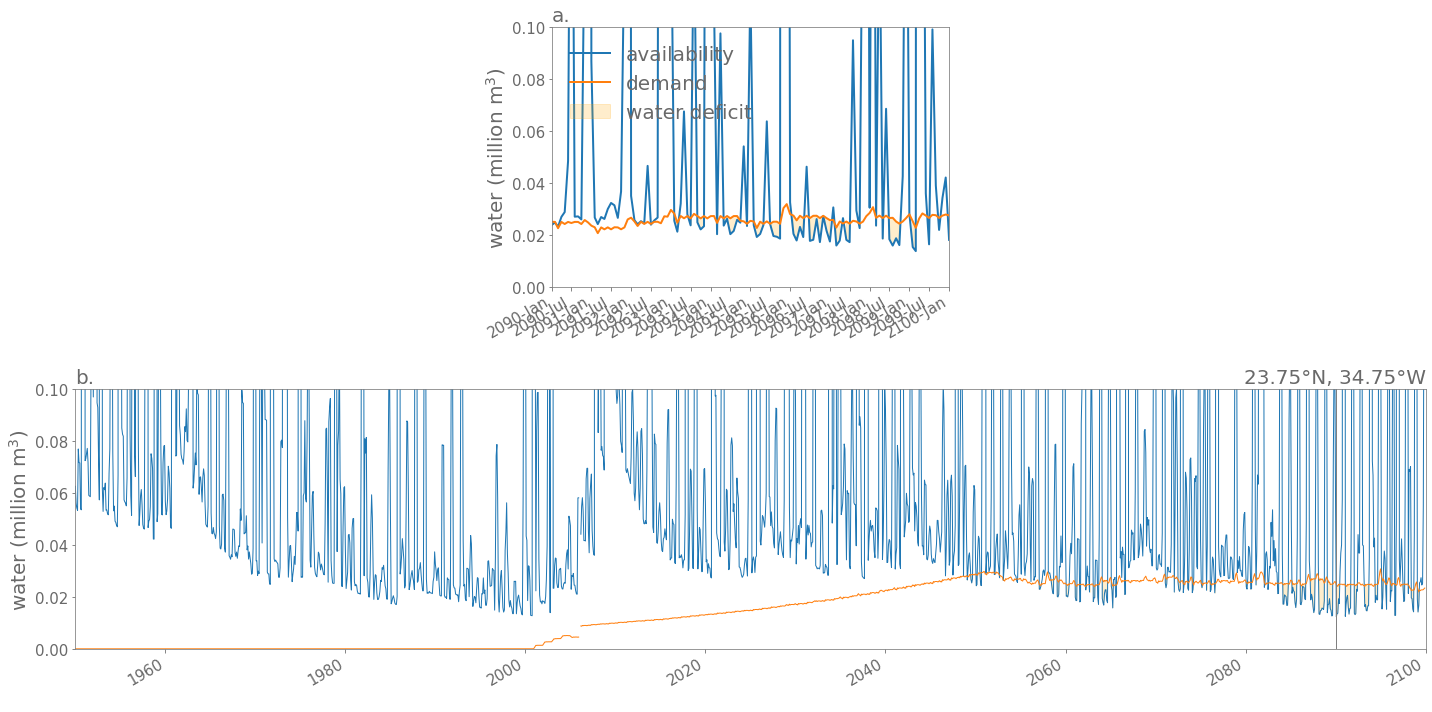

In [64]:
# zoomed figure

import matplotlib.dates as mdates


fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid(shape=(2,3), loc=(0,1), colspan=1)


minzoom= '2090'
maxzoom = '2100'
coordinate = str(wa.lat.values)+'°N, '+str(abs(wa.lon.values))+'°W'

scenario='rcp60'
wa_toplot = (wa.mean('model').sel({'scenario':scenario})*10**-6)
withdrawal_toplot = (withdrawal.mean('model').sel({'scenario':scenario})*10**-6)

#fig, ax = plt.subplots(figsize=(10,5))

wa_toplot.plot(ax=ax1, label='availability', linewidth=2);
withdrawal_toplot.plot(ax=ax1, label='demand', linewidth=2);

ax1.fill_between(wa_toplot.time, wa_toplot , withdrawal_toplot, where =  (wa_toplot) <= (withdrawal_toplot), color='orange' , alpha=0.2, label='water deficit')

ax1.legend(frameon=False, fontsize=20);
ax1.set_ylabel('water (million m$^3$)', fontsize=20); 
ax1.set_ylim(0,0.1);
ax1.set_xlim(pd.to_datetime(minzoom+'-01-01'),pd.to_datetime(maxzoom+'-01-01'));
ax1.tick_params(labelsize=15)
# Make ticks on occurrences of each month:

ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
# Get only the month to show in the x-axis:
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_xlabel(' ')

ax1.set_title('a.', loc='left', fontsize=20);
ax1.set_title(' ', loc='center');

# ------------------------------------------------------------------------------------------------------------------------------------------------
ax = plt.subplot2grid((2,3), (1,0), colspan=3)

# larger figure

wa_series_toplot = xr.concat([wa.sel({'scenario':'historical'}),wa.sel({'scenario':'rcp26'})], dim='time').mean('model').rolling(time=3, center=True).mean()*10**-6
withdrawal_series_toplot = xr.concat([withdrawal.sel({'scenario':'historical'}),withdrawal.sel({'scenario':'rcp26'})], dim='time').mean('model').rolling(time=3, center=True).mean()*10**-6

waterdeficit_series_toplot = xr.concat([water_deficit_annual.sel({'scenario':'historical'}).where(water_deficit_annual.time<2006),water_deficit_annual.sel({'scenario':'rcp26'}).where(water_deficit_annual.time>2005)], dim='time').mean('model')*10**-6/12
waterdeficit_series_toplot['time'] = pd.to_datetime(waterdeficit_series_toplot.time, format='%Y')

#fig, ax = plt.subplots(figsize=(20,5))

wa_series_toplot.plot(ax=ax, label='availability', linewidth=1);
withdrawal_series_toplot.plot(ax=ax, label='demand', linewidth=1);
#waterdeficit_series_toplot.plot(ax=ax, label='deficit', linewidth=1);

ax.fill_between(wa_series_toplot.time, wa_series_toplot, withdrawal_series_toplot, where =  (wa_series_toplot) <= (withdrawal_series_toplot), color='orange' , alpha=0.2, label='water deficit')

#ax.legend(frameon=False, fontsize=20);
ax.set_ylabel('water (million m$^3$)', fontsize=20); 
ax.set_ylim(0,0.1);
ax.set_xlabel(' ')
ax.set_xlim(pd.to_datetime('1950-01-01'),pd.to_datetime('2100-01-01'));
ax.tick_params(labelsize=15)

# Make ticks on occurrences of each month:
#ax.xaxis.set_major_locator(mdates.MonthLocator())

# Get only the month to show in the x-axis:
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.set_title(coordinate, loc='right', fontsize=20);
ax.set_title(' ', loc='center');
ax.set_title('b.', loc='left', fontsize=20);

xmin = np.where(waterdeficit_series_toplot.time.values ==(pd.to_datetime('1960-01-01')))[0][0]
xmax = np.where(waterdeficit_series_toplot.time.values ==(pd.to_datetime('2035-01-01')))[0][0]

#ax.hlines(y=600, xmin=pd.to_datetime('1960-01-01'), xmax=pd.to_datetime('2035-01-01'), color='grey', linewidth=2)
yloc = 600
yearmin= '1960'
yearmax = '2035'
yeartext = '1980'
#ax.annotate(" ", xy=(pd.to_datetime(yearmin+'-01-01'), yloc), xytext=(pd.to_datetime(yearmax+'-01-01'), yloc),
 #           arrowprops=dict( arrowstyle='<|-', color='gray', linewidth=2, alpha=0.7))
#ax.text( pd.to_datetime(yeartext+'-01-01'), yloc+30, "Average lifetime of 60-year old in 2020", fontsize=15)

#ax.axvline(x = pd.to_datetime(yearmin+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)

# 2020
yloc = 700
yearmin= '2020'
yearmax = '2100'
yeartext = '2030'
#ax.annotate(" ", xy=(pd.to_datetime(yearmin+'-01-01'), yloc), xytext=(pd.to_datetime(yearmax+'-01-01'), yloc),
#            arrowprops=dict( arrowstyle='<|-', color='gray', linewidth=2, alpha=0.7))
#ax.text( pd.to_datetime(yeartext+'-01-01'), yloc+30, "Average lifetime of 0-year old in 2020", fontsize=15)

ax.axvline(x = pd.to_datetime(minzoom+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)
ax.axvline(x = pd.to_datetime(maxzoom+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)

fig.tight_layout()

In [32]:
gridcell = [41.75,-112.75] # Salt Lake City/ Utah
wa, withdrawal, water_deficit_annual = load_deficit_gridcell(gridcell, models, scenarios, forcings, process_simulations=False)

Load saved pickles


In [26]:
gridcell = [29.25,5.25] # Algeria
wa, withdrawal, water_deficit_annual = load_deficit_gridcell(gridcell, models, scenarios, forcings, process_simulations=False)

Load saved pickles


In [39]:
gridcell = [6.25,38.25] # Kenya? -- double check
wa, withdrawal, water_deficit_annual = load_deficit_gridcell(gridcell, models, scenarios, forcings, process_simulations=False)

Load saved pickles


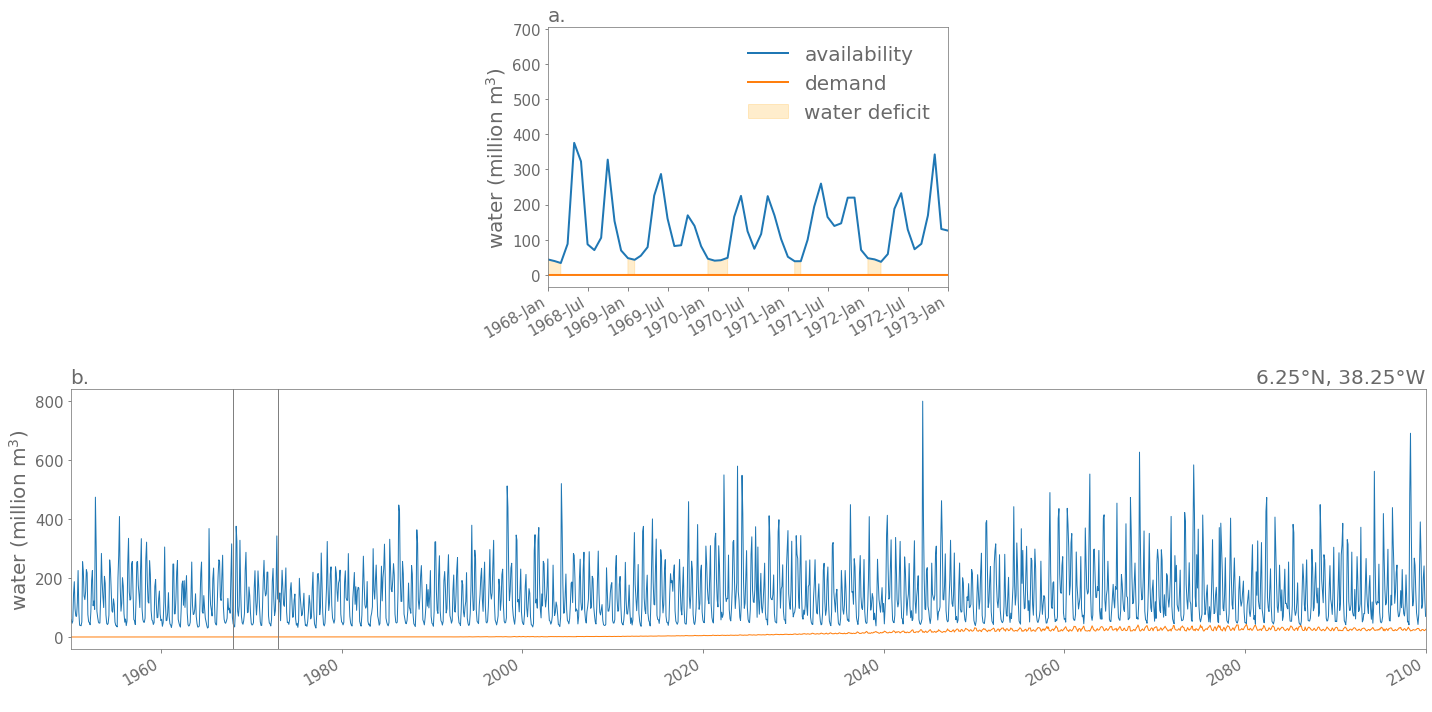

In [43]:
# zoomed figure

import matplotlib.dates as mdates


fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid(shape=(2,3), loc=(0,1), colspan=1)


minzoom= '1968'
maxzoom = '1973'
coordinate = str(wa.lat.values)+'°N, '+str(abs(wa.lon.values))+'°W'

scenario='historical'
wa_toplot = (wa.mean('model').sel({'scenario':scenario})*10**-6)
withdrawal_toplot = (withdrawal.mean('model').sel({'scenario':scenario})*10**-6)

#fig, ax = plt.subplots(figsize=(10,5))

wa_toplot.plot(ax=ax1, label='availability', linewidth=2);
withdrawal_toplot.plot(ax=ax1, label='demand', linewidth=2);

ax1.fill_between(wa_toplot.time, wa_toplot , withdrawal_toplot, where =  (wa_toplot-50) <= (withdrawal_toplot), color='orange' , alpha=0.2, label='water deficit')

ax1.legend(frameon=False, fontsize=20);
ax1.set_ylabel('water (million m$^3$)', fontsize=20); 
#ax1.set_ylim(0,10);
ax1.set_xlim(pd.to_datetime(minzoom+'-01-01'),pd.to_datetime(maxzoom+'-01-01'));
ax1.tick_params(labelsize=15)
# Make ticks on occurrences of each month:

ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
# Get only the month to show in the x-axis:
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_xlabel(' ')

ax1.set_title('a.', loc='left', fontsize=20);
ax1.set_title(' ', loc='center');

# ------------------------------------------------------------------------------------------------------------------------------------------------
ax = plt.subplot2grid((2,3), (1,0), colspan=3)

# larger figure

wa_series_toplot = xr.concat([wa.sel({'scenario':'historical'}),wa.sel({'scenario':'rcp26'})], dim='time').mean('model').rolling(time=1, center=True).mean()*10**-6
withdrawal_series_toplot = xr.concat([withdrawal.sel({'scenario':'historical'}),withdrawal.sel({'scenario':'rcp26'})], dim='time').mean('model').rolling(time=1, center=True).mean()*10**-6

waterdeficit_series_toplot = xr.concat([water_deficit_annual.sel({'scenario':'historical'}).where(water_deficit_annual.time<2006),water_deficit_annual.sel({'scenario':'rcp26'}).where(water_deficit_annual.time>2005)], dim='time').mean('model')*10**-6/12
waterdeficit_series_toplot['time'] = pd.to_datetime(waterdeficit_series_toplot.time, format='%Y')

#fig, ax = plt.subplots(figsize=(20,5))

wa_series_toplot.plot(ax=ax, label='availability', linewidth=1);
withdrawal_series_toplot.plot(ax=ax, label='demand', linewidth=1);
#waterdeficit_series_toplot.plot(ax=ax, label='deficit', linewidth=1);

ax.fill_between(wa_series_toplot.time, wa_series_toplot, withdrawal_series_toplot, where =  (wa_series_toplot) <= (withdrawal_series_toplot), color='orange' , alpha=0.2, label='water deficit')

#ax.legend(frameon=False, fontsize=20);
ax.set_ylabel('water (million m$^3$)', fontsize=20); 
#ax.set_ylim(0,10);
ax.set_xlabel(' ')
ax.set_xlim(pd.to_datetime('1950-01-01'),pd.to_datetime('2100-01-01'));
ax.tick_params(labelsize=15)

# Make ticks on occurrences of each month:
#ax.xaxis.set_major_locator(mdates.MonthLocator())

# Get only the month to show in the x-axis:
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.set_title(coordinate, loc='right', fontsize=20);
ax.set_title(' ', loc='center');
ax.set_title('b.', loc='left', fontsize=20);

xmin = np.where(waterdeficit_series_toplot.time.values ==(pd.to_datetime('1960-01-01')))[0][0]
xmax = np.where(waterdeficit_series_toplot.time.values ==(pd.to_datetime('2035-01-01')))[0][0]

#ax.hlines(y=600, xmin=pd.to_datetime('1960-01-01'), xmax=pd.to_datetime('2035-01-01'), color='grey', linewidth=2)
yloc = 600
yearmin= '1960'
yearmax = '2035'
yeartext = '1980'
#ax.annotate(" ", xy=(pd.to_datetime(yearmin+'-01-01'), yloc), xytext=(pd.to_datetime(yearmax+'-01-01'), yloc),
 #           arrowprops=dict( arrowstyle='<|-', color='gray', linewidth=2, alpha=0.7))
#ax.text( pd.to_datetime(yeartext+'-01-01'), yloc+30, "Average lifetime of 60-year old in 2020", fontsize=15)

#ax.axvline(x = pd.to_datetime(yearmin+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)

# 2020
yloc = 700
yearmin= '2020'
yearmax = '2100'
yeartext = '2030'
#ax.annotate(" ", xy=(pd.to_datetime(yearmin+'-01-01'), yloc), xytext=(pd.to_datetime(yearmax+'-01-01'), yloc),
#            arrowprops=dict( arrowstyle='<|-', color='gray', linewidth=2, alpha=0.7))
#ax.text( pd.to_datetime(yeartext+'-01-01'), yloc+30, "Average lifetime of 0-year old in 2020", fontsize=15)

ax.axvline(x = pd.to_datetime(minzoom+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)
ax.axvline(x = pd.to_datetime(maxzoom+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)

fig.tight_layout()

In [34]:
gridcell = [36.5,-3.25] # Southern Spain
wa, withdrawal, water_deficit_annual = load_deficit_gridcell(gridcell, models, scenarios, forcings, process_simulations=False)

Load saved pickles


FileNotFoundError: [Errno 2] No such file or directory: './data/intermediate/d_gridcell_deficit_36.5_ -3.25.pkl'

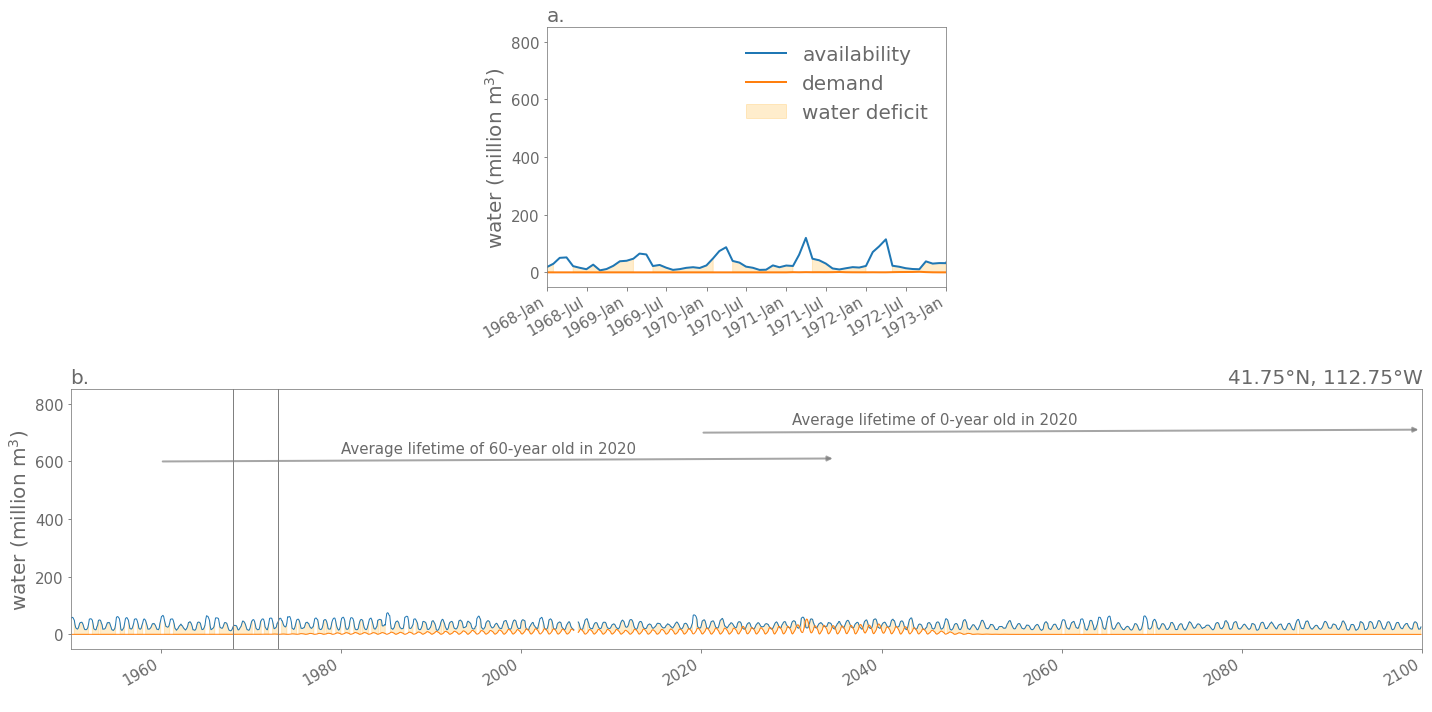

In [35]:
# zoomed figure

import matplotlib.dates as mdates


fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid(shape=(2,3), loc=(0,1), colspan=1)


minzoom= '1968'
maxzoom = '1973'
coordinate = str(wa.lat.values)+'°N, '+str(abs(wa.lon.values))+'°W'

scenario='historical'
wa_toplot = (wa.mean('model').sel({'scenario':scenario})*10**-6)
withdrawal_toplot = (withdrawal.mean('model').sel({'scenario':scenario})*10**-6)

#fig, ax = plt.subplots(figsize=(10,5))

wa_toplot.plot(ax=ax1, label='availability', linewidth=2);
withdrawal_toplot.plot(ax=ax1, label='demand', linewidth=2);

ax1.fill_between(wa_toplot.time, wa_toplot , withdrawal_toplot, where =  (wa_toplot-50) <= (withdrawal_toplot), color='orange' , alpha=0.2, label='water deficit')

ax1.legend(frameon=False, fontsize=20);
ax1.set_ylabel('water (million m$^3$)', fontsize=20); 
ax1.set_ylim(-50,850);
ax1.set_xlim(pd.to_datetime(minzoom+'-01-01'),pd.to_datetime(maxzoom+'-01-01'));
ax1.tick_params(labelsize=15)
# Make ticks on occurrences of each month:

ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
# Get only the month to show in the x-axis:
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_xlabel(' ')

ax1.set_title('a.', loc='left', fontsize=20);
ax1.set_title(' ', loc='center');

# ------------------------------------------------------------------------------------------------------------------------------------------------
ax = plt.subplot2grid((2,3), (1,0), colspan=3)

# larger figure

wa_series_toplot = xr.concat([wa.sel({'scenario':'historical'}),wa.sel({'scenario':'rcp26'})], dim='time').mean('model').rolling(time=6, center=True).mean()*10**-6
withdrawal_series_toplot = xr.concat([withdrawal.sel({'scenario':'historical'}),withdrawal.sel({'scenario':'rcp26'})], dim='time').mean('model').rolling(time=6, center=True).mean()*10**-6

waterdeficit_series_toplot = xr.concat([water_deficit_annual.sel({'scenario':'historical'}).where(water_deficit_annual.time<2006),water_deficit_annual.sel({'scenario':'rcp26'}).where(water_deficit_annual.time>2005)], dim='time').mean('model')*10**-6/12
waterdeficit_series_toplot['time'] = pd.to_datetime(waterdeficit_series_toplot.time, format='%Y')

#fig, ax = plt.subplots(figsize=(20,5))

wa_series_toplot.plot(ax=ax, label='availability', linewidth=1);
withdrawal_series_toplot.plot(ax=ax, label='demand', linewidth=1);
#waterdeficit_series_toplot.plot(ax=ax, label='deficit', linewidth=1);

ax.fill_between(wa_series_toplot.time, wa_series_toplot, withdrawal_series_toplot, where =  (wa_series_toplot-50) <= (withdrawal_series_toplot), color='orange' , alpha=0.2, label='water deficit')

#ax.legend(frameon=False, fontsize=20);
ax.set_ylabel('water (million m$^3$)', fontsize=20); 
ax.set_ylim(-50,850);
ax.set_xlabel(' ')
ax.set_xlim(pd.to_datetime('1950-01-01'),pd.to_datetime('2100-01-01'));
ax.tick_params(labelsize=15)

# Make ticks on occurrences of each month:
#ax.xaxis.set_major_locator(mdates.MonthLocator())

# Get only the month to show in the x-axis:
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.set_title(coordinate, loc='right', fontsize=20);
ax.set_title(' ', loc='center');
ax.set_title('b.', loc='left', fontsize=20);

xmin = np.where(waterdeficit_series_toplot.time.values ==(pd.to_datetime('1960-01-01')))[0][0]
xmax = np.where(waterdeficit_series_toplot.time.values ==(pd.to_datetime('2035-01-01')))[0][0]

#ax.hlines(y=600, xmin=pd.to_datetime('1960-01-01'), xmax=pd.to_datetime('2035-01-01'), color='grey', linewidth=2)
yloc = 600
yearmin= '1960'
yearmax = '2035'
yeartext = '1980'
ax.annotate(" ", xy=(pd.to_datetime(yearmin+'-01-01'), yloc), xytext=(pd.to_datetime(yearmax+'-01-01'), yloc),
            arrowprops=dict( arrowstyle='<|-', color='gray', linewidth=2, alpha=0.7))
ax.text( pd.to_datetime(yeartext+'-01-01'), yloc+30, "Average lifetime of 60-year old in 2020", fontsize=15)

#ax.axvline(x = pd.to_datetime(yearmin+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)

# 2020
yloc = 700
yearmin= '2020'
yearmax = '2100'
yeartext = '2030'
ax.annotate(" ", xy=(pd.to_datetime(yearmin+'-01-01'), yloc), xytext=(pd.to_datetime(yearmax+'-01-01'), yloc),
            arrowprops=dict( arrowstyle='<|-', color='gray', linewidth=2, alpha=0.7))
ax.text( pd.to_datetime(yeartext+'-01-01'), yloc+30, "Average lifetime of 0-year old in 2020", fontsize=15)

ax.axvline(x = pd.to_datetime(minzoom+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)
ax.axvline(x = pd.to_datetime(maxzoom+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)

fig.tight_layout()

In [6]:
# OLD tries of grid cells

gridcell = [50.75,4.25] # Brussels
gridcell = [30.25,28.25] # Cairo

gridcell = [6.25,38.25] # Kenya? -- double check
gridcell = [30.25,28.25] # Cairo
gridcell = [30.25,-9.25] # Morroco
gridcell = [37.25,-3.75] # Spain



Loading model H08
Loading model MATSIRO
Loading model H08
Loading model MATSIRO


In [6]:
# calculate mean per country weighted by population
country = 'Morocco'
wa_country, withdrawal_country, water_deficit_annual_country = load_deficit_country(country, models, scenarios, forcings, pop, countries_mask, countries_regions, process_simulations=False)

Load saved pickles


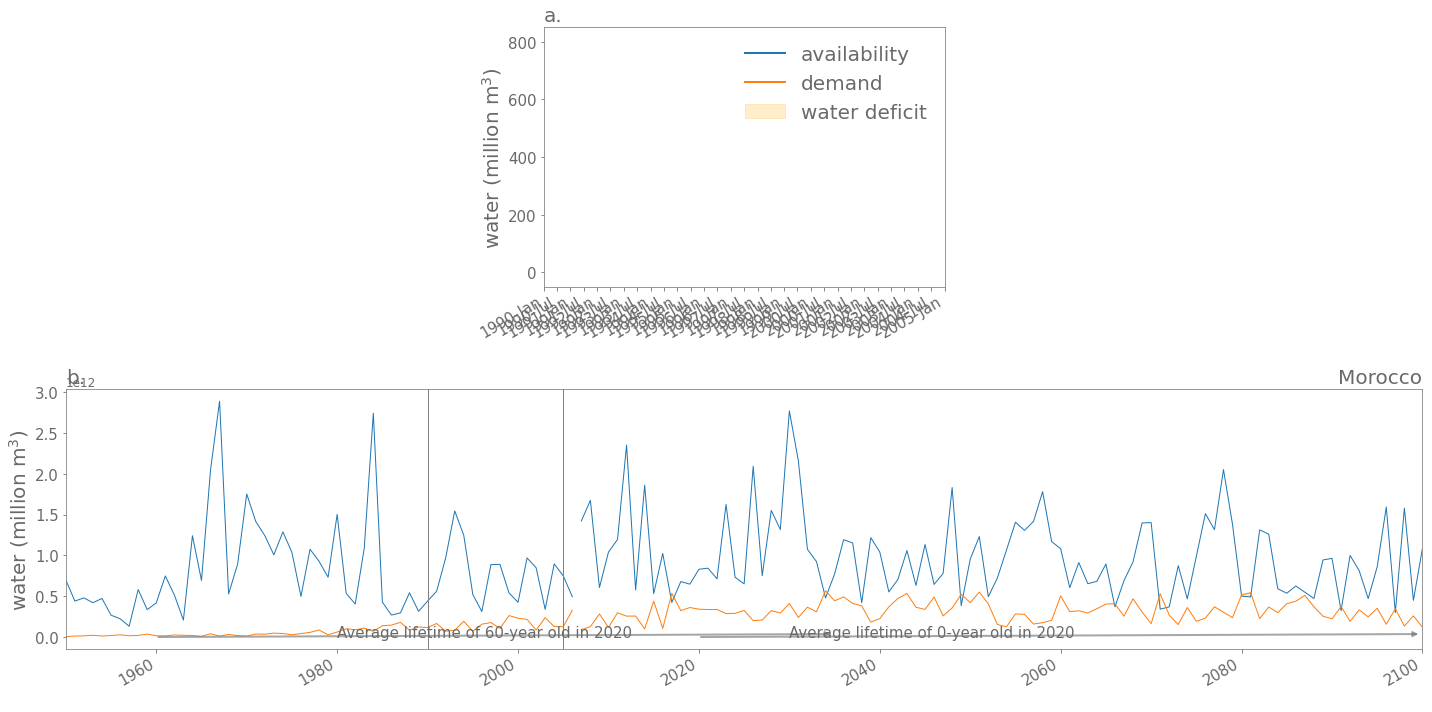

In [11]:
# zoomed figure

rolling_time = 1

import matplotlib.dates as mdates


fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid(shape=(2,3), loc=(0,1), colspan=1)


minzoom= '1990'
maxzoom = '2005'


scenario='historical'
wa_toplot = (wa.mean(dim=('model','forcing')).sel({'scenario':scenario})*10**-6)
withdrawal_toplot = (withdrawal.mean(dim=('model','forcing')).sel({'scenario':scenario})*10**-6)

#fig, ax = plt.subplots(figsize=(10,5))

wa_toplot.plot(ax=ax1, label='availability', linewidth=2);
withdrawal_toplot.plot(ax=ax1, label='demand', linewidth=2);

ax1.fill_between(wa_toplot.time, wa_toplot , withdrawal_toplot, where =  (wa_toplot-50) <= (withdrawal_toplot), color='orange' , alpha=0.2, label='water deficit')

ax1.legend(frameon=False, fontsize=20);
ax1.set_ylabel('water (million m$^3$)', fontsize=20); 
ax1.set_ylim(-50,850);
ax1.set_xlim(pd.to_datetime(minzoom+'-01-01'),pd.to_datetime(maxzoom+'-01-01'));
ax1.tick_params(labelsize=15)
# Make ticks on occurrences of each month:

ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
# Get only the month to show in the x-axis:
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_xlabel(' ')

ax1.set_title('a.', loc='left', fontsize=20);
ax1.set_title(' ', loc='center');

# ------------------------------------------------------------------------------------------------------------------------------------------------
ax = plt.subplot2grid((2,3), (1,0), colspan=3)

# larger figure

wa_series_toplot = xr.concat([wa.sel({'scenario':'historical'}),wa.sel({'scenario':'rcp26'})], dim='time').mean(dim=('model','forcing')).rolling(time=rolling_time, center=True).mean()*10**-6
withdrawal_series_toplot = xr.concat([withdrawal.sel({'scenario':'historical'}),withdrawal.sel({'scenario':'rcp26'})], dim='time').mean(dim=('model','forcing')).rolling(time=rolling_time, center=True).mean()*10**-6

waterdeficit_series_toplot = xr.concat([water_deficit_annual.sel({'scenario':'historical'}).where(water_deficit_annual.time<2006),water_deficit_annual.sel({'scenario':'rcp26'}).where(water_deficit_annual.time>2005)], dim='time').mean(dim=('model','forcing'))*10**-6/12
waterdeficit_series_toplot['time'] = pd.to_datetime(waterdeficit_series_toplot.time, format='%Y')

#fig, ax = plt.subplots(figsize=(20,5))

wa_series_toplot.plot(ax=ax, label='availability', linewidth=1);
withdrawal_series_toplot.plot(ax=ax, label='demand', linewidth=1);
#waterdeficit_series_toplot.plot(ax=ax, label='deficit', linewidth=1);

ax.fill_between(wa_series_toplot.time, wa_series_toplot, withdrawal_series_toplot, where =  (wa_series_toplot-50) <= (withdrawal_series_toplot), color='orange' , alpha=0.2, label='water deficit')

#ax.legend(frameon=False, fontsize=20);
ax.set_ylabel('water (million m$^3$)', fontsize=20); 
#ax.set_ylim(-50,850);
ax.set_xlabel(' ')
ax.set_xlim(pd.to_datetime('1950-01-01'),pd.to_datetime('2100-01-01'));
ax.tick_params(labelsize=15)

# Make ticks on occurrences of each month:
#ax.xaxis.set_major_locator(mdates.MonthLocator())

# Get only the month to show in the x-axis:
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.set_title(country, loc='right', fontsize=20);
ax.set_title(' ', loc='center');
ax.set_title('b.', loc='left', fontsize=20);

xmin = np.where(waterdeficit_series_toplot.time.values ==(pd.to_datetime('1960-01-01')))[0][0]
xmax = np.where(waterdeficit_series_toplot.time.values ==(pd.to_datetime('2035-01-01')))[0][0]

#ax.hlines(y=600, xmin=pd.to_datetime('1960-01-01'), xmax=pd.to_datetime('2035-01-01'), color='grey', linewidth=2)
yloc = 600
yearmin= '1960'
yearmax = '2035'
yeartext = '1980'
ax.annotate(" ", xy=(pd.to_datetime(yearmin+'-01-01'), yloc), xytext=(pd.to_datetime(yearmax+'-01-01'), yloc),
            arrowprops=dict( arrowstyle='<|-', color='gray', linewidth=2, alpha=0.7))
ax.text( pd.to_datetime(yeartext+'-01-01'), yloc+30, "Average lifetime of 60-year old in 2020", fontsize=15)

#ax.axvline(x = pd.to_datetime(yearmin+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)

# 2020
yloc = 700
yearmin= '2020'
yearmax = '2100'
yeartext = '2030'
ax.annotate(" ", xy=(pd.to_datetime(yearmin+'-01-01'), yloc), xytext=(pd.to_datetime(yearmax+'-01-01'), yloc),
            arrowprops=dict( arrowstyle='<|-', color='gray', linewidth=2, alpha=0.7))
ax.text( pd.to_datetime(yeartext+'-01-01'), yloc+30, "Average lifetime of 0-year old in 2020", fontsize=15)

ax.axvline(x = pd.to_datetime(minzoom+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)
ax.axvline(x = pd.to_datetime(maxzoom+'-01-01'), ymin=0, ymax= 1, color='grey', linewidth=1)

fig.tight_layout()

In [9]:
# calculate mean per country weighted by population
country = 'Tanzania'
wa, withdrawal, water_deficit_annual = load_deficit_country(country, models, scenarios, forcings, pop, countries_mask, countries_regions, process_simulations=True)

Load and process all simulations
Loading model LPJmL
Loading model CWatM
Loading model MATSIRO
Loading model H08
Loading model LPJmL
Loading model CWatM
Loading model MATSIRO
Loading model H08


In [ ]:
# calculate mean per country weighted by population
country = 'Madagascar'
wa, withdrawal, water_deficit_annual = load_deficit_country(country, models, scenarios, forcings, pop, countries_mask, countries_regions, process_simulations=True)

In [ ]:
# calculate mean per country weighted by population
country = 'Mauritania'
wa, withdrawal, water_deficit_annual = load_deficit_country(country, models, scenarios, forcings, pop, countries_mask, countries_regions, process_simulations=True)